# PREVISÃO DE PROPRIEDADES MECÂNICAS DE MATERIAIS COMPÓSITOS USANDO ELEMENTOS FINITOS E APRENDIZADO DE MÁQUINA

### Trabalho de conclusão de curso

Douglas Ricardo Sansão

Fevereiro de 2021

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 1. Combinações para simulação em FEM

In [2]:
# número de combinações a gerar
n_points = 1000
# fixo um seed fixo, para gerar a mesma combinação
np.random.seed(111)
# fração volumétrica
v_f = np.random.uniform(low=0.05, high=0.75, size=n_points)
v_f = [np.round(i, 2) for i in v_f]
# módulo de elasticidade da matriz
E_m = np.random.uniform(low=5, high=10, size=n_points)
E_m = [np.round(i, 2) for i in E_m]
# módulo de cisalhamento da matriz
G_m = np.random.uniform(low=1, high=5, size=n_points)
G_m = [np.round(i, 2) for i in G_m]
# módulo de elasticidade da fibra
E_f = np.random.uniform(low=50, high=150, size=n_points)
E_f = [np.round(i, 0) for i in E_f]
# módulo de cisalhamento da fibra
G_f = np.random.uniform(low=5, high=50, size=n_points)
G_f = [np.round(i, 0) for i in G_f]
# dataframe final, no mesmo formato a ser importado no comsol
df = pd.DataFrame({'v_f':v_f, 'E_m':E_m, 'G_m':G_m,'E_f':E_f, 'G_f':G_f}).transpose()
# salvo em parametros_comsol.csv
df.to_csv('parametros_simulacoes.csv', header=False)
df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
v_f,0.48,0.17,0.36,0.59,0.26,0.15,0.07,0.34,0.22,0.29,...,0.72,0.39,0.27,0.70,0.38,0.68,0.20,0.20,0.64,0.12
E_m,7.60,8.91,9.04,6.25,9.80,5.94,6.42,8.78,7.47,9.81,...,6.06,5.86,7.41,7.41,9.30,9.68,6.29,5.28,6.42,5.14
G_m,4.17,1.27,4.58,3.11,2.61,2.46,3.65,1.82,1.31,2.43,...,4.24,3.00,4.13,3.37,2.48,2.78,2.87,3.29,4.46,1.80
E_f,139.00,140.00,142.00,51.00,88.00,74.00,51.00,127.00,149.00,103.00,...,102.00,86.00,76.00,141.00,73.00,124.00,139.00,116.00,94.00,60.00
G_f,18.00,46.00,25.00,30.00,26.00,18.00,17.00,33.00,23.00,33.00,...,12.00,48.00,16.00,20.00,43.00,47.00,31.00,7.00,35.00,21.00


----------------------------------------------------------------------------------------------------------------

### 2. Modelos teóricos vs FEM

In [3]:
# leio o resultado das simulações para fibra de vidro
df = pd.read_csv('resultado_fibra_de_vidro_fem.csv', header=4)
# fico somente com as colunas que interessam
df = df.drop(['group.cp11', 'group.cp22','group.cp33', 
              'group.cp12', 'group.cp23','group.cp13','loadcase', 
              ], axis=1)
# renomeio as colunas
dic_columns = {'% v_f':'v_f',
               "Fiber Young's modulus, 11 direction (Pa)":'E_f',
               'Fiber shear modulus, 12 direction (Pa)':'G_f',
               "Resin Young's modulus (Pa)":'E_m',
               'Resin shear modulus (Pa)':'G_m',
              'Elasticity matrix, 11 component (N/m^2)':'E1',
              'Elasticity matrix, 22 component (N/m^2)':'E2',
              'Elasticity matrix, 44 component (N/m^2)':'G12'}
df = df.rename(columns=dic_columns)
df

,v_f,E_m,G_m,E_f,G_f,E1,E2,G12
0,0.1,3.760000e+09,1280000000,7.300000e+10,3.042000e+10,1.068269e+10,4.472351e+09,2.244648e+09
1,0.2,3.760000e+09,1280000000,7.300000e+10,3.042000e+10,1.760715e+10,5.398611e+09,2.687611e+09
2,0.3,3.760000e+09,1280000000,7.300000e+10,3.042000e+10,2.453147e+10,6.639323e+09,3.239883e+09
3,0.4,3.760000e+09,1280000000,7.300000e+10,3.042000e+10,3.145565e+10,8.376854e+09,3.955270e+09
4,0.5,3.760000e+09,1280000000,7.300000e+10,3.042000e+10,3.837976e+10,1.100150e+10,4.938500e+09
5,0.6,3.760000e+09,1280000000,7.300000e+10,3.042000e+10,4.530372e+10,1.559132e+10,6.430889e+09
6,0.7,3.760000e+09,1280000000,7.300000e+10,3.042000e+10,5.222779e+10,2.694469e+10,9.177193e+09


Implementação dos modelos teóricos

In [4]:
# ROM
df['E1_rom'] = df['v_f']*df['E_f'] + (1-df['v_f'])*df['E_m']
df['E2_rom'] = (df['E_f']*df['E_m'])/(df['E_m']*df['v_f']+df['E_f']*(1-df['v_f']))
df['G12_rom'] = (df['G_f']*df['G_m'])/(df['G_m']*df['v_f']+df['G_f']*(1-df['v_f']))
# CH
df['E1_cha'] = df['E_m']+df['v_f']*(df['E_f']-df['E_m'])
df['E2_cha'] = df['E_m']/(1-np.sqrt(df['v_f'])*(1-df['E_m']/df['E_f']))
df['G12_cha'] = df['G_m']/(1-np.sqrt(df['v_f'])*(1-df['G_m']/df['G_f']))
# HTM
epsilon=2
df['E1_htm'] = df['v_f']*df['E_f'] + (1-df['v_f'])*df['E_m']
eta = ((df['E_f']/df['E_m'])-1)/((df['E_f']/df['E_m'])+epsilon)
df['E2_htm'] = df['E_m']*(1+epsilon*eta*df['v_f'])/(1-eta*df['v_f'])
eta = ((df['G_f']/df['G_m'])-1)/((df['G_f']/df['G_m'])+epsilon)
df['G12_htm'] = df['G_m']*(1+epsilon*eta*df['v_f'])/(1-eta*df['v_f'])

# Relações para plotar
df['E1_fem/E_m'] = df['E1']/df['E_m']
df['E1_rom/E_m'] = df['E1_rom']/df['E_m']
df['E1_cha/E_m'] = df['E1_cha']/df['E_m']
df['E1_htm/E_m'] = df['E1_htm']/df['E_m']
df['E2_fem/E_m'] = df['E2']/df['E_m']
df['E2_rom/E_m'] = df['E2_rom']/df['E_m']
df['E2_cha/E_m'] = df['E2_cha']/df['E_m']
df['E2_htm/E_m'] = df['E2_htm']/df['E_m']
df['G12_fem/G_m'] = df['G12']/df['G_m']
df['G12_rom/G_m'] = df['G12_rom']/df['G_m']
df['G12_cha/G_m'] = df['G12_cha']/df['G_m']
df['G12_htm/G_m'] = df['G12_htm']/df['G_m']

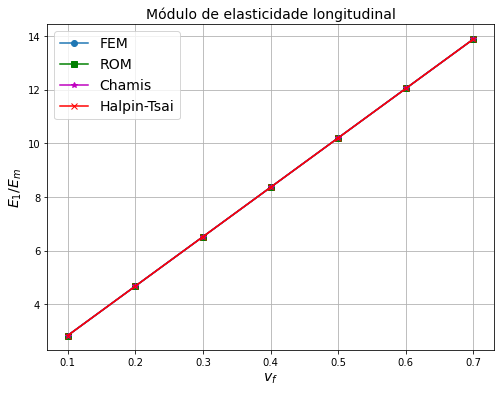

In [5]:
# plot E1
ax = df.plot(x='v_f', y='E1_fem/E_m', grid=True, marker='o', figsize=(8,6), label='FEM')
df.plot(x='v_f', y='E1_rom/E_m', grid=True, marker='s', figsize=(8,6), label='ROM', ax=ax, c='g')
df.plot(x='v_f', y='E1_cha/E_m', grid=True, marker='*', figsize=(8,6), label='Chamis', ax=ax, c='m')
df.plot(x='v_f', y='E1_htm/E_m', grid=True, marker='x', figsize=(8,6), label='Halpin-Tsai', ax=ax, c='r')
plt.xlabel('$v_f$', fontsize=14)
plt.ylabel('$E_1/E_m$',fontsize=14)
plt.title('Módulo de elasticidade longitudinal', fontsize=14)
plt.legend(prop={'size': 14})
#plt.savefig('E1 fem vs modelos.png', dpi=500)

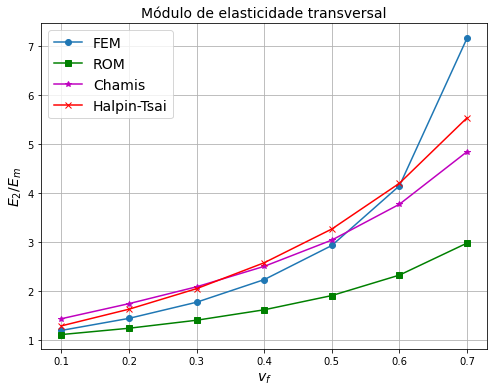

In [6]:
# plot E2
ax = df.plot(x='v_f', y='E2_fem/E_m', grid=True, marker='o', figsize=(8,6), label='FEM')
df.plot(x='v_f', y='E2_rom/E_m', grid=True, marker='s', figsize=(8,6), label='ROM', ax=ax, c='g')
df.plot(x='v_f', y='E2_cha/E_m', grid=True, marker='*', figsize=(8,6), label='Chamis', ax=ax, c='m')
df.plot(x='v_f', y='E2_htm/E_m', grid=True, marker='x', figsize=(8,6), label='Halpin-Tsai', ax=ax, c='r')
plt.xlabel('$v_f$', fontsize=14)
plt.ylabel('$E_2/E_m$',fontsize=14)
plt.title('Módulo de elasticidade transversal',fontsize=14)
plt.legend(prop={'size': 14})
#plt.savefig('E2 fem vs modelos.png', dpi=500)

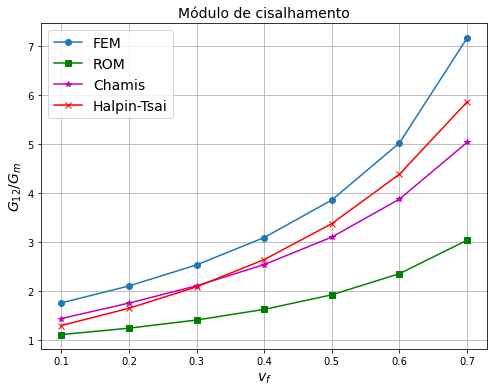

In [7]:
# plot G12
ax = df.plot(x='v_f', y='G12_fem/G_m', grid=True, marker='o', figsize=(8,6), label='FEM')
df.plot(x='v_f', y='G12_rom/G_m', grid=True, marker='s', figsize=(8,6), label='ROM', ax=ax, c='g')
df.plot(x='v_f', y='G12_cha/G_m', grid=True, marker='*', figsize=(8,6), label='Chamis', ax=ax, c='m')
df.plot(x='v_f', y='G12_htm/G_m', grid=True, marker='x', figsize=(8,6), label='Halpin-Tsai', ax=ax, c='r')
plt.xlabel('$v_f$', fontsize=14)
plt.ylabel('$G_{12}/G_m$',fontsize=14)
plt.title('Módulo de cisalhamento', fontsize=14)
plt.legend(prop={'size': 14})
#plt.savefig('G12 fem vs modelos.png', dpi=500)

--------------------------------------------------------------------------------------

In [8]:
# leio 'resultado_simulacoes_fem.csv', que é exportado do COMSOL
df = pd.read_csv('resultado_simulacoes_fem.csv', header=4)
# fico somente com as colunas que interessam
df = df.drop(['group.cp11', 'group.cp22','group.cp33', 
              'group.cp12', 'group.cp23','group.cp13','loadcase',
              'E_m (GPa)', 'G_m (GPa)', 'E1_f (GPa)', 'G12_f (GPa)'
              ], axis=1)
# renomeio colunas
dic_columns = {'% v_f':'v_f',
               "Fiber Young's modulus, 11 direction (Pa)":'E_f',
               'Fiber shear modulus, 12 direction (Pa)':'G_f',
               "Resin Young's modulus (Pa)":'E_m',
               'Resin shear modulus (Pa)':'G_m',
              'Elasticity matrix, 11 component (N/m^2)':'E1',
              'Elasticity matrix, 22 component (N/m^2)':'E2',
              'Elasticity matrix, 44 component (N/m^2)':'G12'}
df = df.rename(columns=dic_columns)
df.head()

,v_f,E_m,G_m,E_f,G_f,E1,E2,G12
0,0.48,7.600000e+09,4.170000e+09,1.390000e+11,1.800000e+10,7.067121e+10,1.856350e+10,7.292388e+09
1,0.17,8.910000e+09,1.270000e+09,1.400000e+11,4.600000e+10,3.119393e+10,1.166959e+10,5.905773e+09
2,0.36,9.040000e+09,4.580000e+09,1.420000e+11,2.500000e+10,5.690500e+10,1.676563e+10,7.539605e+09
3,0.59,6.250000e+09,3.110000e+09,5.100000e+10,3.000000e+10,3.265232e+10,1.695101e+10,9.152172e+09
4,0.26,9.800000e+09,2.610000e+09,8.800000e+10,2.600000e+10,3.013148e+10,1.447014e+10,7.017454e+09


In [9]:
# ROM
df['E1_rom'] = df['v_f']*df['E_f'] + (1-df['v_f'])*df['E_m']
df['E2_rom'] = (df['E_f']*df['E_m'])/(df['E_m']*df['v_f']+df['E_f']*(1-df['v_f']))
df['G12_rom'] = (df['G_f']*df['G_m'])/(df['G_m']*df['v_f']+df['G_f']*(1-df['v_f']))
# CH
df['E1_cha'] = df['E_m']+df['v_f']*(df['E_f']-df['E_m'])
df['E2_cha'] = df['E_m']/(1-np.sqrt(df['v_f'])*(1-df['E_m']/df['E_f']))
df['G12_cha'] = df['G_m']/(1-np.sqrt(df['v_f'])*(1-df['G_m']/df['G_f']))
# HTM
epsilon=2
df['E1_htm'] = df['v_f']*df['E_f'] + (1-df['v_f'])*df['E_m']
eta = ((df['E_f']/df['E_m'])-1)/((df['E_f']/df['E_m'])+epsilon)
df['E2_htm'] = df['E_m']*(1+epsilon*eta*df['v_f'])/(1-eta*df['v_f'])

# Relação
df['E2_fem/E_m'] = df['E2']/df['E_m']
df['E2_rom/E_m'] = df['E2_rom']/df['E_m']
df['E2_cha/E_m'] = df['E2_cha']/df['E_m']
df['E2_htm/E_m'] = df['E2_htm']/df['E_m']

Text(0.5, 1.0, 'Módulo de elasticidade transversal (1000 simulações)')

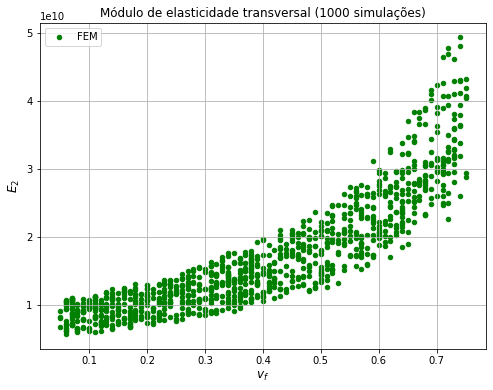

In [10]:
ax = df.plot(x='v_f', y='E2', grid=True, marker='o', figsize=(8,6), label='FEM', kind='scatter', c='g')
plt.ylabel('$E_2$', fontsize=12)
plt.xlabel('$v_f$', fontsize=12)
plt.title('Módulo de elasticidade transversal (1000 simulações)')
#plt.savefig('E2 simulacoes.png', dpi=500)

Text(0.5, 0.92, 'Módulo de elasticidade transversal')

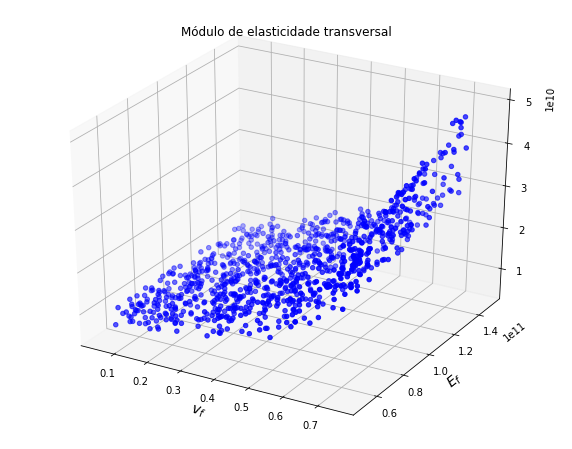

In [11]:
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = df['E2']
xdata = df['v_f']
ydata = df['E_f']
ax.scatter3D(xdata, ydata, zdata, c='b');
plt.xlabel('$v_f$', fontsize=14)
plt.ylabel('$E_f$', fontsize=14)
plt.title('Módulo de elasticidade transversal')

-------------------------------------------------------------------------

### 3. Visualização - Árvore de decisão

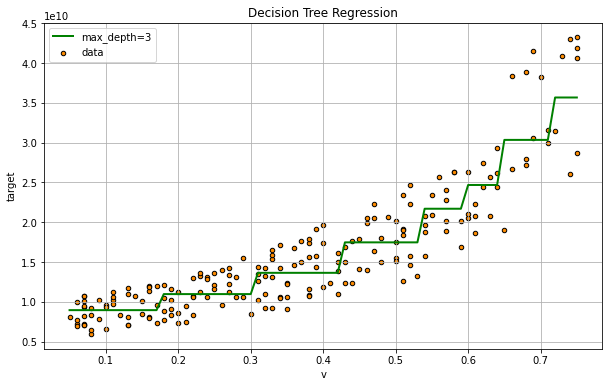

In [90]:
X = df[['v_f']].values
y = df[['E2']].values

# Import cross validation tools from scikit
from sklearn.model_selection import train_test_split
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

temp = pd.DataFrame({'X_test':X_test.ravel(), 'y_test':y_test.ravel()}).sort_values(by='X_test')
X_test = temp.X_test.to_numpy().reshape([int(test_size*X.shape[0]),1])
y_test = temp.y_test.to_numpy().reshape([int(test_size*X.shape[0]),1])

from sklearn.tree import DecisionTreeRegressor
max_depth = 3

# Fit regression model
regr = DecisionTreeRegressor(max_depth=max_depth)
regr.fit(X_train, y_train)

# Predict
y = regr.predict(X_test)

# Plot the results
plt.figure(figsize=(10,6))
plt.scatter(X_test, y_test, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot(X_test, y, color="green", label=f"max_depth={max_depth}", linewidth=2)
plt.grid(True)
plt.xlabel("v")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

In [17]:
temp = pd.DataFrame({'y_test':y_test.ravel(), 'y_pred':regr.predict(X_test)})
temp['error'] = temp['y_test']-temp['y_pred']
temp['sq_error'] = temp['error']**2
temp['abs_perc_error'] = np.abs(temp['error'])/temp['y_test']
temp['y_centered'] = temp['y_test']-temp['y_test'].mean()
temp['sq_y_centered'] = temp['y_centered']**2
temp.head()

,y_test,y_pred,error,sq_error,abs_perc_error,y_centered,sq_y_centered
0,8.134408e+09,8.960625e+09,-8.262171e+08,6.826348e+17,0.101571,-7.807334e+09,6.095446e+19
1,7.208002e+09,8.960625e+09,-1.752623e+09,3.071688e+18,0.243150,-8.733740e+09,7.627821e+19
2,6.982381e+09,8.960625e+09,-1.978245e+09,3.913452e+18,0.283320,-8.959362e+09,8.027016e+19
3,1.002714e+10,8.960625e+09,1.066512e+09,1.137448e+18,0.106363,-5.914605e+09,3.498255e+19
4,7.672399e+09,8.960625e+09,-1.288226e+09,1.659527e+18,0.167904,-8.269343e+09,6.838203e+19


### 4. Plot erros em função da profundidade

In [27]:
r2_list_test = []
mape_list_test = []
mse_list_test = []

r2_list_train = []
mape_list_train = []
mse_list_train = []

depth_list = list(range(3,16))

for max_depth in depth_list:
    x_columns = ['v_f','E_m','G_m','E_f','G_f']
    y_columns = ['G12']

    X = df[x_columns].values
    y = df[y_columns].values

    # Import cross validation tools from scikit
    from sklearn.model_selection import train_test_split
    test_size = 0.2

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

    from sklearn.tree import DecisionTreeRegressor

    # Fit regression model
    regr = DecisionTreeRegressor(max_depth=max_depth)
    regr.fit(X_train, y_train)

    # Predict  test
    y_pred = regr.predict(X_test)
    
    pd_X_test = pd.DataFrame(X_test)
    pd_y_test = pd.DataFrame(y_test)
    pd_y_pred = pd.DataFrame(y_pred)

    pd_X_test.columns = x_columns
    pd_y_test.columns = pd.Series(y_columns)+'_test'
    pd_y_pred.columns = pd.Series(y_columns)+'_pred'

    temp = pd.DataFrame({'y_test':y_test.ravel(), 'y_pred':regr.predict(X_test)})
    temp['error'] = temp['y_test']-temp['y_pred']
    temp['sq_error'] = temp['error']**2
    temp['abs_perc_error'] = np.abs(temp['error'])/temp['y_test']
    temp['y_centered'] = temp['y_test']-temp['y_test'].mean()
    temp['sq_y_centered'] = temp['y_centered']**2

    mape_list_test.append(temp['abs_perc_error'].mean())
    mse_list_test.append(temp['sq_error'].mean())
    r2_list_test.append(regr.score(X_test, y_test))
    
    
    # Predict train
    y_pred = regr.predict(X_train)
    
    pd_X_train = pd.DataFrame(X_train)
    pd_y_train = pd.DataFrame(y_train)
    pd_y_pred = pd.DataFrame(y_pred)

    pd_X_train.columns = x_columns
    pd_y_train.columns = pd.Series(y_columns)+'_train'
    pd_y_pred.columns = pd.Series(y_columns)+'_pred'

    temp = pd.DataFrame({'y_train':y_train.ravel(), 'y_pred':regr.predict(X_train)})
    temp['error'] = temp['y_train']-temp['y_pred']
    temp['sq_error'] = temp['error']**2
    temp['abs_perc_error'] = np.abs(temp['error'])/temp['y_train']
    temp['y_centered'] = temp['y_train']-temp['y_train'].mean()
    temp['sq_y_centered'] = temp['y_centered']**2
    
    mape_list_train.append(temp['abs_perc_error'].mean())
    mse_list_train.append(temp['sq_error'].mean())
    r2_list_train.append(regr.score(X_train, y_train))

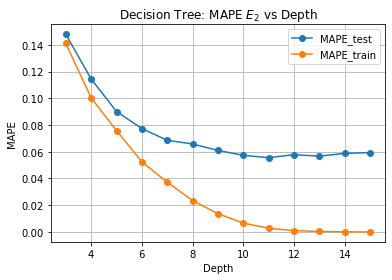

In [28]:
temp = pd.DataFrame({'depth':depth_list, 'mape_test':mape_list_test, 'r2_test':r2_list_test, 'mse_test':mse_list_test,
                                        'mape_train':mape_list_train, 'r2_train':r2_list_train, 'mse_train':mse_list_train})
plt.plot(temp['depth'], temp['mape_test'], label='MAPE_test', marker='o')
plt.plot(temp['depth'], temp['mape_train'], label='MAPE_train', marker='o')
plt.title('Decision Tree: MAPE $E_{2}$ vs Depth')
plt.xlabel('Depth')
plt.ylabel('MAPE')
plt.legend()
plt.grid(True)
#plt.savefig('MAPE E2 vs depth 10-30.png', dpi=500)

In [91]:
# alterar aqui:
max_depth = 8
y_name = 'G12'

x_columns = ['v_f','E_m','G_m','E_f','G_f']
y_columns = [y_name]

X = df[x_columns].values
y = df[y_columns].values

# Import cross validation tools from scikit
from sklearn.model_selection import train_test_split
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

from sklearn.tree import DecisionTreeRegressor

# Fit regression model
regr = DecisionTreeRegressor(max_depth=max_depth, random_state=1)
regr.fit(X_train, y_train)

# Predict
y_pred = regr.predict(X_test)

pd_X_test = pd.DataFrame(X_test)
pd_y_test = pd.DataFrame(y_test)
pd_y_pred = pd.DataFrame(y_pred)

pd_X_test.columns = x_columns
pd_y_test.columns = pd.Series(y_columns)+'_test'
pd_y_pred.columns = pd.Series(y_columns)+'_pred'

temp = pd.concat([pd_X_test, pd_y_test, pd_y_pred], axis=1).sort_values(by=['v_f'])
temp = temp.rename(columns={y_columns[0]+'_test':'y_test', y_columns[0]+'_pred':'y_pred'})
temp['mape'] = np.abs((temp['y_test']-temp['y_pred'])/temp['y_test'])

print('MAPE '+y_columns[0])
print(temp['mape'].mean())

MAPE G12
0.06453726561159173


MAPE E1 <br>
0.0589411541516848 <br>

MAPE E2<br>
0.04536977194439428 <br>

MAPE G12 <br>
0.06453726561159173 <br>

### 5. Árvore de decisão

In [32]:
# E1
max_depth = 8

r2_list = []
mape_list = []
mse_list = []

x_columns = ['v_f','E_m','G_m','E_f','G_f']
y_columns = ['E1']

X = df[x_columns].values
y = df[y_columns].values

# Import cross validation tools from scikit
from sklearn.model_selection import train_test_split
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

from sklearn.tree import DecisionTreeRegressor

# Fit regression model
rng = np.random.RandomState(1)
regr = DecisionTreeRegressor(max_depth=max_depth, random_state=1)
regr.fit(X_train, y_train.ravel())

# Predict  test
y_pred = regr.predict(X_test)

pd_X_test = pd.DataFrame(X_test)
pd_y_test = pd.DataFrame(y_test)
pd_y_pred = pd.DataFrame(y_pred)

pd_X_test.columns = x_columns
pd_y_test.columns = pd.Series(y_columns)+'_test'
pd_y_pred.columns = pd.Series(y_columns)+'_pred'

temp_test = pd.DataFrame({'y_test':y_test.ravel(), 'y_pred':regr.predict(X_test)})
temp_test['error'] = temp_test['y_test']-temp_test['y_pred']
temp_test['sq_error'] = temp_test['error']**2
temp_test['abs_perc_error'] = np.abs(temp_test['error'])/temp_test['y_test']
temp_test['y_centered'] = temp_test['y_test']-temp_test['y_test'].mean()
temp_test['sq_y_centered'] = temp_test['y_centered']**2

mape_list.append(temp_test['abs_perc_error'].mean())
mse_list.append(temp_test['sq_error'].mean())
r2_list.append(regr.score(X_test, y_test))

results = pd.concat([pd_X_test, pd_y_test, pd_y_pred], axis=1).rename(columns={'E1_test':'E1_true','E1_pred':'E1_pred'})

# ROM
results['E1_rom'] = results['v_f']*results['E_f'] + (1-results['v_f'])*results['E_m']
results['E2_rom'] = (results['E_f']*results['E_m'])/(results['E_m']*results['v_f']+results['E_f']*(1-results['v_f']))
results['G12_rom'] = (results['G_f']*results['G_m'])/(results['G_m']*results['v_f']+results['G_f']*(1-results['v_f']))

# CH
results['E1_cha'] = results['E_m']+results['v_f']*(results['E_f']-results['E_m'])
results['E2_cha'] = results['E_m']/(1-np.sqrt(results['v_f'])*(1-results['E_m']/results['E_f']))
results['G12_cha'] = results['G_m']/(1-np.sqrt(results['v_f'])*(1-results['G_m']/results['G_f']))

# HTM
results['E1_htm'] = results['v_f']*results['E_f'] + (1-results['v_f'])*results['E_m']
epsilon=2

eta = ((results['E_f']/results['E_m'])-1)/((results['E_f']/results['E_m'])+epsilon)
results['E2_htm'] = results['E_m']*(1+epsilon*eta*results['v_f'])/(1-eta*results['v_f'])

eta = ((results['G_f']/results['G_m'])-1)/((results['G_f']/results['G_m'])+epsilon)
results['G12_htm'] = results['G_m']*(1+epsilon*eta*results['v_f'])/(1-eta*results['v_f'])


results['MAPE_rom'] = np.abs((results['E1_true']-results['E1_rom'])/results['E1_true'])
results['MAPE_cha'] = np.abs((results['E1_true']-results['E1_cha'])/results['E1_true'])
results['MAPE_htm'] = np.abs((results['E1_true']-results['E1_htm'])/results['E1_true'])
results['MAPE_bdt'] = np.abs((results['E1_true']-results['E1_pred'])/results['E1_true'])

results = results.sort_values(by='v_f')

E1_results = results[results.columns[results.columns.str.contains('MAPE')]].mean().rename('E1')

In [33]:
# E2
max_depth = 10

r2_list = []
mape_list = []
mse_list = []

x_columns = ['v_f','E_m','G_m','E_f','G_f']
y_columns = ['E2']

X = df[x_columns].values
y = df[y_columns].values

# Import cross validation tools from scikit
from sklearn.model_selection import train_test_split
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

from sklearn.tree import DecisionTreeRegressor

# Fit regression model
rng = np.random.RandomState(1)
regr = DecisionTreeRegressor(max_depth=max_depth, random_state=1)
regr.fit(X_train, y_train.ravel())

# Predict  test
y_pred = regr.predict(X_test)

pd_X_test = pd.DataFrame(X_test)
pd_y_test = pd.DataFrame(y_test)
pd_y_pred = pd.DataFrame(y_pred)

pd_X_test.columns = x_columns
pd_y_test.columns = pd.Series(y_columns)+'_test'
pd_y_pred.columns = pd.Series(y_columns)+'_pred'

temp_test = pd.DataFrame({'y_test':y_test.ravel(), 'y_pred':regr.predict(X_test)})
temp_test['error'] = temp_test['y_test']-temp_test['y_pred']
temp_test['sq_error'] = temp_test['error']**2
temp_test['abs_perc_error'] = np.abs(temp_test['error'])/temp_test['y_test']
temp_test['y_centered'] = temp_test['y_test']-temp_test['y_test'].mean()
temp_test['sq_y_centered'] = temp_test['y_centered']**2

mape_list.append(temp_test['abs_perc_error'].mean())
mse_list.append(temp_test['sq_error'].mean())
r2_list.append(regr.score(X_test, y_test))

results = pd.concat([pd_X_test, pd_y_test, pd_y_pred], axis=1).rename(columns={'E2_test':'E2_true','E2_pred':'E2_pred'})

# ROM
results['E1_rom'] = results['v_f']*results['E_f'] + (1-results['v_f'])*results['E_m']
results['E2_rom'] = (results['E_f']*results['E_m'])/(results['E_m']*results['v_f']+results['E_f']*(1-results['v_f']))
results['G12_rom'] = (results['G_f']*results['G_m'])/(results['G_m']*results['v_f']+results['G_f']*(1-results['v_f']))

# CH
results['E1_cha'] = results['E_m']+results['v_f']*(results['E_f']-results['E_m'])
results['E2_cha'] = results['E_m']/(1-np.sqrt(results['v_f'])*(1-results['E_m']/results['E_f']))
results['G12_cha'] = results['G_m']/(1-np.sqrt(results['v_f'])*(1-results['G_m']/results['G_f']))

# HTM
results['E1_htm'] = results['v_f']*results['E_f'] + (1-results['v_f'])*results['E_m']
epsilon=2

eta = ((results['E_f']/results['E_m'])-1)/((results['E_f']/results['E_m'])+epsilon)
results['E2_htm'] = results['E_m']*(1+epsilon*eta*results['v_f'])/(1-eta*results['v_f'])

eta = ((results['G_f']/results['G_m'])-1)/((results['G_f']/results['G_m'])+epsilon)
results['G12_htm'] = results['G_m']*(1+epsilon*eta*results['v_f'])/(1-eta*results['v_f'])


results['MAPE_rom'] = np.abs((results['E2_true']-results['E2_rom'])/results['E2_true'])
results['MAPE_cha'] = np.abs((results['E2_true']-results['E2_cha'])/results['E2_true'])
results['MAPE_htm'] = np.abs((results['E2_true']-results['E2_htm'])/results['E2_true'])
results['MAPE_bdt'] = np.abs((results['E2_true']-results['E2_pred'])/results['E2_true'])

results = results.sort_values(by='v_f')

E2_results = results[results.columns[results.columns.str.contains('MAPE')]].mean().rename('E2')

In [34]:
# G12
max_depth = 8

r2_list = []
mape_list = []
mse_list = []

x_columns = ['v_f','E_m','G_m','E_f','G_f']
y_columns = ['G12']

X = df[x_columns].values
y = df[y_columns].values

# Import cross validation tools from scikit
from sklearn.model_selection import train_test_split
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

from sklearn.tree import DecisionTreeRegressor

# Fit regression model
rng = np.random.RandomState(1)
regr = DecisionTreeRegressor(max_depth=max_depth, random_state=1)
regr.fit(X_train, y_train.ravel())

# Predict  test
y_pred = regr.predict(X_test)

pd_X_test = pd.DataFrame(X_test)
pd_y_test = pd.DataFrame(y_test)
pd_y_pred = pd.DataFrame(y_pred)

pd_X_test.columns = x_columns
pd_y_test.columns = pd.Series(y_columns)+'_test'
pd_y_pred.columns = pd.Series(y_columns)+'_pred'

temp_test = pd.DataFrame({'y_test':y_test.ravel(), 'y_pred':regr.predict(X_test)})
temp_test['error'] = temp_test['y_test']-temp_test['y_pred']
temp_test['sq_error'] = temp_test['error']**2
temp_test['abs_perc_error'] = np.abs(temp_test['error'])/temp_test['y_test']
temp_test['y_centered'] = temp_test['y_test']-temp_test['y_test'].mean()
temp_test['sq_y_centered'] = temp_test['y_centered']**2

mape_list.append(temp_test['abs_perc_error'].mean())
mse_list.append(temp_test['sq_error'].mean())
r2_list.append(regr.score(X_test, y_test))

results = pd.concat([pd_X_test, pd_y_test, pd_y_pred], axis=1).rename(columns={'G12_test':'G12_true','G12_pred':'G12_pred'})

# ROM
results['E1_rom'] = results['v_f']*results['E_f'] + (1-results['v_f'])*results['E_m']
results['E2_rom'] = (results['E_f']*results['E_m'])/(results['E_m']*results['v_f']+results['E_f']*(1-results['v_f']))
results['G12_rom'] = (results['G_f']*results['G_m'])/(results['G_m']*results['v_f']+results['G_f']*(1-results['v_f']))

# CH
results['E1_cha'] = results['E_m']+results['v_f']*(results['E_f']-results['E_m'])
results['E2_cha'] = results['E_m']/(1-np.sqrt(results['v_f'])*(1-results['E_m']/results['E_f']))
results['G12_cha'] = results['G_m']/(1-np.sqrt(results['v_f'])*(1-results['G_m']/results['G_f']))

# HTM
results['E1_htm'] = results['v_f']*results['E_f'] + (1-results['v_f'])*results['E_m']
epsilon=2

eta = ((results['E_f']/results['E_m'])-1)/((results['E_f']/results['E_m'])+epsilon)
results['E2_htm'] = results['E_m']*(1+epsilon*eta*results['v_f'])/(1-eta*results['v_f'])

eta = ((results['G_f']/results['G_m'])-1)/((results['G_f']/results['G_m'])+epsilon)
results['G12_htm'] = results['G_m']*(1+epsilon*eta*results['v_f'])/(1-eta*results['v_f'])

results['MAPE_rom'] = np.abs((results['G12_true']-results['G12_rom'])/results['G12_true'])
results['MAPE_cha'] = np.abs((results['G12_true']-results['G12_cha'])/results['G12_true'])
results['MAPE_htm'] = np.abs((results['G12_true']-results['G12_htm'])/results['G12_true'])
results['MAPE_bdt'] = np.abs((results['G12_true']-results['G12_pred'])/results['G12_true'])

results = results.sort_values(by='v_f')

G12_results = results[results.columns[results.columns.str.contains('MAPE')]].mean().rename('G12')

In [35]:
resultado_final = pd.concat([E1_results,E2_results,G12_results], axis=1)*100
resultado_final = resultado_final.transpose()
resultado_final['L_dt'] = [8,10,8]
resultado_final = resultado_final.rename(columns={'MAPE_bdt':'MAPE_dt'})
resultado_final

,MAPE_rom,MAPE_cha,MAPE_htm,MAPE_dt,L_dt
E1,0.002888,0.002888,0.002888,5.894115,8
E2,17.526942,18.732548,16.196371,4.536977,10
G12,35.457049,29.120323,26.211844,6.453727,8


### 6. Árvore decisão com Adaboost

In [92]:
from sklearn.ensemble import AdaBoostRegressor

In [93]:
r2_list = []
mape_list = []
mse_list = []

r2_list_train = []
mape_list_train = []
mse_list_train = []


depth_list = list(range(3,15))

for max_depth in depth_list:
    x_columns = ['v_f','E_m','G_m','E_f','G_f']
    y_columns = ['G12']

    X = df[x_columns].values
    y = df[y_columns].values

    # Import cross validation tools from scikit
    from sklearn.model_selection import train_test_split
    test_size = 0.2

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

    from sklearn.tree import DecisionTreeRegressor

    # Fit regression model
    rng = np.random.RandomState(1)
    regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=max_depth),
                          n_estimators=50, random_state=rng)
    regr.fit(X_train, y_train.ravel())

    # Predict  test
    y_pred = regr.predict(X_test)
    
    pd_X_test = pd.DataFrame(X_test)
    pd_y_test = pd.DataFrame(y_test)
    pd_y_pred = pd.DataFrame(y_pred)

    pd_X_test.columns = x_columns
    pd_y_test.columns = pd.Series(y_columns)+'_test'
    pd_y_pred.columns = pd.Series(y_columns)+'_pred'

    temp = pd.DataFrame({'y_test':y_test.ravel(), 'y_pred':regr.predict(X_test)})
    temp['error'] = temp['y_test']-temp['y_pred']
    temp['sq_error'] = temp['error']**2
    temp['abs_perc_error'] = np.abs(temp['error'])/temp['y_test']
    temp['y_centered'] = temp['y_test']-temp['y_test'].mean()
    temp['sq_y_centered'] = temp['y_centered']**2

    mape_list.append(temp['abs_perc_error'].mean())
    mse_list.append(temp['sq_error'].mean())
    r2_list.append(regr.score(X_test, y_test))
    
    
    # Predict train
    y_pred = regr.predict(X_train)
    
    pd_X_train = pd.DataFrame(X_train)
    pd_y_train = pd.DataFrame(y_train)
    pd_y_pred = pd.DataFrame(y_pred)

    pd_X_train.columns = x_columns
    pd_y_train.columns = pd.Series(y_columns)+'_train'
    pd_y_pred.columns = pd.Series(y_columns)+'_pred'

    temp = pd.DataFrame({'y_train':y_train.ravel(), 'y_pred':regr.predict(X_train)})
    temp['error'] = temp['y_train']-temp['y_pred']
    temp['sq_error'] = temp['error']**2
    temp['abs_perc_error'] = np.abs(temp['error'])/temp['y_train']
    temp['y_centered'] = temp['y_train']-temp['y_train'].mean()
    temp['sq_y_centered'] = temp['y_centered']**2
    
    mape_list_train.append(temp['abs_perc_error'].mean())
    mse_list_train.append(temp['sq_error'].mean())
    r2_list_train.append(regr.score(X_train, y_train))

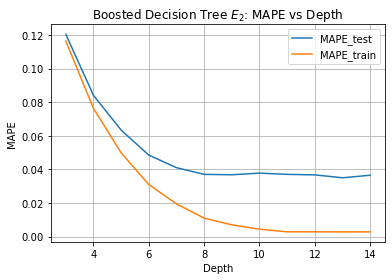

In [94]:
temp = pd.DataFrame({'depth':depth_list, 'mape_test':mape_list, 'r2':r2_list, 'mse_test':mse_list,
                                        'mape_train':mape_list_train, 'r2_train':r2_list_train, 'mse_train':mse_list_train})
plt.plot(temp['depth'], temp['mape_test'], label='MAPE_test')
plt.plot(temp['depth'], temp['mape_train'], label='MAPE_train')
plt.title('Boosted Decision Tree $E_2$: MAPE vs Depth')
plt.xlabel('Depth')
plt.ylabel('MAPE')
plt.legend()
plt.grid(True)

E1: 8 <br>
E2: 9 <br>
G12: 9 <br>

In [99]:
max_depth = 9

x_columns = ['v_f','E_m','G_m','E_f','G_f']
y_columns = ['E2']

X = df[x_columns].values
y = df[y_columns].values

# Import cross validation tools from scikit
from sklearn.model_selection import train_test_split
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

from sklearn.tree import DecisionTreeRegressor

# Fit regression model
rng = np.random.RandomState(1)
regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=max_depth),
                      n_estimators=50, random_state=rng)
regr.fit(X_train, y_train.ravel())

# Predict  test
y_pred = regr.predict(X_test)

pd_X_test = pd.DataFrame(X_test)
pd_y_test = pd.DataFrame(y_test)
pd_y_pred = pd.DataFrame(y_pred)

pd_X_test.columns = x_columns
pd_y_test.columns = pd.Series(y_columns)+'_test'
pd_y_pred.columns = pd.Series(y_columns)+'_pred'

temp_test = pd.DataFrame({'y_test':y_test.ravel(), 'y_pred':regr.predict(X_test)})
temp_test['error'] = temp_test['y_test']-temp_test['y_pred']
temp_test['sq_error'] = temp_test['error']**2
temp_test['abs_perc_error'] = np.abs(temp_test['error'])/temp_test['y_test']
temp_test['y_centered'] = temp_test['y_test']-temp_test['y_test'].mean()
temp_test['sq_y_centered'] = temp_test['y_centered']**2

mape_list.append(temp_test['abs_perc_error'].mean())
mse_list.append(temp_test['sq_error'].mean())
r2_list.append(regr.score(X_test, y_test))

# Plot the results
temp = pd.concat([pd_X_test, pd_y_test, pd_y_pred], axis=1).sort_values(by=['v_f'])
temp = temp.rename(columns={y_columns[0]+'_test':'y_test', y_columns[0]+'_pred':'y_pred'})
temp['mape'] = np.abs((temp['y_test']-temp['y_pred'])/temp['y_test'])

results = pd.concat([pd_X_test, pd_y_test, pd_y_pred], axis=1).rename(columns={'E2_test':'E2_true','E2_pred':'E2_pred'})

results['E2_rom'] = (results['E_f']*results['E_m'])/(results['E_m']*results['v_f']+results['E_f']*(1-results['v_f']))
results['E2_cha'] = results['E_m']/(1-np.sqrt(results['v_f'])*(1-results['E_m']/results['E_f']))
eta = ((results['E_f']/results['E_m'])-1)/((results['E_f']/results['E_m'])+epsilon)
results['E2_htm'] = results['E_m']*(1+epsilon*eta*results['v_f'])/(1-eta*results['v_f'])

results['MAPE_rom'] = np.abs((results['E2_true']-results['E2_rom'])/results['E2_true'])
results['MAPE_cha'] = np.abs((results['E2_true']-results['E2_cha'])/results['E2_true'])
results['MAPE_htm'] = np.abs((results['E2_true']-results['E2_htm'])/results['E2_true'])
results['MAPE_bdt'] = np.abs((results['E2_true']-results['E2_pred'])/results['E2_true'])

results = results.sort_values(by='v_f')
results

,v_f,E_m,G_m,E_f,G_f,E2_true,E2_pred,E2_rom,E2_cha,E2_htm,MAPE_rom,MAPE_cha,MAPE_htm,MAPE_bdt
24,0.05,7.570000e+09,1.890000e+09,8.000000e+10,4.900000e+10,8.134408e+09,8.956136e+09,7.928933e+09,9.491544e+09,8.468663e+09,0.025260,0.166839,0.041091,0.101019
199,0.06,6.610000e+09,2.470000e+09,7.000000e+10,2.800000e+10,7.208002e+09,7.871778e+09,6.989785e+09,8.494166e+09,7.559693e+09,0.030274,0.178435,0.048792,0.092089
167,0.06,6.360000e+09,1.100000e+09,1.210000e+11,3.900000e+10,6.982381e+09,7.612643e+09,6.743333e+09,8.282048e+09,7.394675e+09,0.034236,0.186135,0.059048,0.090265
76,0.06,9.170000e+09,4.310000e+09,1.190000e+11,3.000000e+10,1.002714e+10,1.035416e+10,9.707571e+09,1.184867e+10,1.055650e+10,0.031870,0.181660,0.052793,0.032614
78,0.06,7.000000e+09,3.850000e+09,1.120000e+11,4.200000e+10,7.672399e+09,8.350651e+09,7.417219e+09,9.086657e+09,8.105263e+09,0.033260,0.184331,0.056418,0.088402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,0.74,8.460000e+09,1.310000e+09,1.090000e+11,2.600000e+10,4.297011e+10,3.594224e+10,2.665114e+10,4.096175e+10,4.511076e+10,0.379775,0.046739,0.049817,0.163552
5,0.75,9.050000e+09,3.260000e+09,9.000000e+10,1.700000e+10,4.190468e+10,3.730010e+10,2.781050e+10,4.093943e+10,4.383437e+10,0.336339,0.023034,0.046049,0.109882
127,0.75,7.140000e+09,4.020000e+09,1.060000e+11,2.100000e+10,4.063299e+10,3.710948e+10,2.375891e+10,3.712779e+10,4.156475e+10,0.415280,0.086265,0.022931,0.086715
51,0.75,7.370000e+09,2.310000e+09,5.300000e+10,2.800000e+10,2.873547e+10,2.939914e+10,2.080202e+10,2.897000e+10,2.994506e+10,0.276085,0.008162,0.042094,0.023096


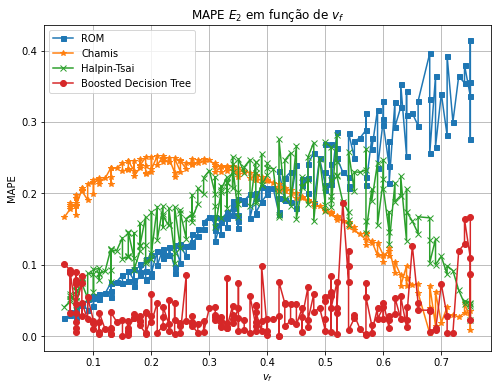

In [100]:
# plot E2
plt.figure(figsize=(8,6))
plt.plot(results['v_f'], results['MAPE_rom'], label='ROM', marker='s', markersize=5)
plt.plot(results['v_f'], results['MAPE_cha'], label='Chamis', marker='*')
plt.plot(results['v_f'], results['MAPE_htm'], label='Halpin-Tsai', marker='x')
plt.plot(results['v_f'], results['MAPE_bdt'], label='Boosted Decision Tree', marker='o')
plt.title('MAPE $E_2$ em função de $v_f$')
plt.xlabel('$v_f$')
plt.ylabel('MAPE')
plt.grid(True)
plt.legend()
#plt.savefig('mape em funcao de vf.png', dpi=500)

### 7. Adaboost final

In [101]:
# E1
max_depth = 8

x_columns = ['v_f','E_m','G_m','E_f','G_f']
y_columns = ['E1']

X = df[x_columns].values
y = df[y_columns].values

# Import cross validation tools from scikit
from sklearn.model_selection import train_test_split
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

from sklearn.tree import DecisionTreeRegressor

# Fit regression model
rng = np.random.RandomState(1)
regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=max_depth),
                      n_estimators=50, random_state=rng)
regr.fit(X_train, y_train.ravel())

# Predict  test
y_pred = regr.predict(X_test)

pd_X_test = pd.DataFrame(X_test)
pd_y_test = pd.DataFrame(y_test)
pd_y_pred = pd.DataFrame(y_pred)

pd_X_test.columns = x_columns
pd_y_test.columns = pd.Series(y_columns)+'_test'
pd_y_pred.columns = pd.Series(y_columns)+'_pred'

temp_test = pd.DataFrame({'y_test':y_test.ravel(), 'y_pred':regr.predict(X_test)})
temp_test['error'] = temp_test['y_test']-temp_test['y_pred']
temp_test['sq_error'] = temp_test['error']**2
temp_test['abs_perc_error'] = np.abs(temp_test['error'])/temp_test['y_test']
temp_test['y_centered'] = temp_test['y_test']-temp_test['y_test'].mean()
temp_test['sq_y_centered'] = temp_test['y_centered']**2

mape_list.append(temp_test['abs_perc_error'].mean())
mse_list.append(temp_test['sq_error'].mean())
r2_list.append(regr.score(X_test, y_test))

results = pd.concat([pd_X_test, pd_y_test, pd_y_pred], axis=1).rename(columns={'E1_test':'E1_true','E1_pred':'E1_pred'})

# ROM
results['E1_rom'] = results['v_f']*results['E_f'] + (1-results['v_f'])*results['E_m']
results['E2_rom'] = (results['E_f']*results['E_m'])/(results['E_m']*results['v_f']+results['E_f']*(1-results['v_f']))
results['G12_rom'] = (results['G_f']*results['G_m'])/(results['G_m']*results['v_f']+results['G_f']*(1-results['v_f']))

# CH
results['E1_cha'] = results['E_m']+results['v_f']*(results['E_f']-results['E_m'])
results['E2_cha'] = results['E_m']/(1-np.sqrt(results['v_f'])*(1-results['E_m']/results['E_f']))
results['G12_cha'] = results['G_m']/(1-np.sqrt(results['v_f'])*(1-results['G_m']/results['G_f']))

# HTM
results['E1_htm'] = results['v_f']*results['E_f'] + (1-results['v_f'])*results['E_m']
epsilon=2

eta = ((results['E_f']/results['E_m'])-1)/((results['E_f']/results['E_m'])+epsilon)
results['E2_htm'] = results['E_m']*(1+epsilon*eta*results['v_f'])/(1-eta*results['v_f'])

eta = ((results['G_f']/results['G_m'])-1)/((results['G_f']/results['G_m'])+epsilon)
results['G12_htm'] = results['G_m']*(1+epsilon*eta*results['v_f'])/(1-eta*results['v_f'])


results['MAPE_rom'] = np.abs((results['E1_true']-results['E1_rom'])/results['E1_true'])
results['MAPE_cha'] = np.abs((results['E1_true']-results['E1_cha'])/results['E1_true'])
results['MAPE_htm'] = np.abs((results['E1_true']-results['E1_htm'])/results['E1_true'])
results['MAPE_bdt'] = np.abs((results['E1_true']-results['E1_pred'])/results['E1_true'])

results = results.sort_values(by='v_f')
# salvo o modelo
e1_adaboost_model = regr
E1_results = results[results.columns[results.columns.str.contains('MAPE')]].mean().rename('E1')

In [102]:
# E2
max_depth = 9

x_columns = ['v_f','E_m','G_m','E_f','G_f']
y_columns = ['E2']

X = df[x_columns].values
y = df[y_columns].values

# Import cross validation tools from scikit
from sklearn.model_selection import train_test_split
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

from sklearn.tree import DecisionTreeRegressor

# Fit regression model
rng = np.random.RandomState(1)
regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=max_depth),
                      n_estimators=50, random_state=rng)
regr.fit(X_train, y_train.ravel())

# Predict  test
y_pred = regr.predict(X_test)

pd_X_test = pd.DataFrame(X_test)
pd_y_test = pd.DataFrame(y_test)
pd_y_pred = pd.DataFrame(y_pred)

pd_X_test.columns = x_columns
pd_y_test.columns = pd.Series(y_columns)+'_test'
pd_y_pred.columns = pd.Series(y_columns)+'_pred'

temp_test = pd.DataFrame({'y_test':y_test.ravel(), 'y_pred':regr.predict(X_test)})
temp_test['error'] = temp_test['y_test']-temp_test['y_pred']
temp_test['sq_error'] = temp_test['error']**2
temp_test['abs_perc_error'] = np.abs(temp_test['error'])/temp_test['y_test']
temp_test['y_centered'] = temp_test['y_test']-temp_test['y_test'].mean()
temp_test['sq_y_centered'] = temp_test['y_centered']**2

mape_list.append(temp_test['abs_perc_error'].mean())
mse_list.append(temp_test['sq_error'].mean())
r2_list.append(regr.score(X_test, y_test))

results = pd.concat([pd_X_test, pd_y_test, pd_y_pred], axis=1).rename(columns={'E2_test':'E2_true','E2_pred':'E2_pred'})

# ROM
results['E1_rom'] = results['v_f']*results['E_f'] + (1-results['v_f'])*results['E_m']
results['E2_rom'] = (results['E_f']*results['E_m'])/(results['E_m']*results['v_f']+results['E_f']*(1-results['v_f']))
results['G12_rom'] = (results['G_f']*results['G_m'])/(results['G_m']*results['v_f']+results['G_f']*(1-results['v_f']))

# CH
results['E1_cha'] = results['E_m']+results['v_f']*(results['E_f']-results['E_m'])
results['E2_cha'] = results['E_m']/(1-np.sqrt(results['v_f'])*(1-results['E_m']/results['E_f']))
results['G12_cha'] = results['G_m']/(1-np.sqrt(results['v_f'])*(1-results['G_m']/results['G_f']))

# HTM
results['E1_htm'] = results['v_f']*results['E_f'] + (1-results['v_f'])*results['E_m']
epsilon=2

eta = ((results['E_f']/results['E_m'])-1)/((results['E_f']/results['E_m'])+epsilon)
results['E2_htm'] = results['E_m']*(1+epsilon*eta*results['v_f'])/(1-eta*results['v_f'])

eta = ((results['G_f']/results['G_m'])-1)/((results['G_f']/results['G_m'])+epsilon)
results['G12_htm'] = results['G_m']*(1+epsilon*eta*results['v_f'])/(1-eta*results['v_f'])


results['MAPE_rom'] = np.abs((results['E2_true']-results['E2_rom'])/results['E2_true'])
results['MAPE_cha'] = np.abs((results['E2_true']-results['E2_cha'])/results['E2_true'])
results['MAPE_htm'] = np.abs((results['E2_true']-results['E2_htm'])/results['E2_true'])
results['MAPE_bdt'] = np.abs((results['E2_true']-results['E2_pred'])/results['E2_true'])

results = results.sort_values(by='v_f')
# salvo o modelo
e2_adaboost_model = regr
E2_results = results[results.columns[results.columns.str.contains('MAPE')]].mean().rename('E2')

In [103]:
# G12
max_depth = 9

x_columns = ['v_f','E_m','G_m','E_f','G_f']
y_columns = ['G12']

X = df[x_columns].values
y = df[y_columns].values

# Import cross validation tools from scikit
from sklearn.model_selection import train_test_split
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

from sklearn.tree import DecisionTreeRegressor

# Fit regression model
rng = np.random.RandomState(1)
regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=max_depth),
                      n_estimators=50, random_state=rng)
regr.fit(X_train, y_train.ravel())

# Predict  test
y_pred = regr.predict(X_test)

pd_X_test = pd.DataFrame(X_test)
pd_y_test = pd.DataFrame(y_test)
pd_y_pred = pd.DataFrame(y_pred)

pd_X_test.columns = x_columns
pd_y_test.columns = pd.Series(y_columns)+'_test'
pd_y_pred.columns = pd.Series(y_columns)+'_pred'

temp_test = pd.DataFrame({'y_test':y_test.ravel(), 'y_pred':regr.predict(X_test)})
temp_test['error'] = temp_test['y_test']-temp_test['y_pred']
temp_test['sq_error'] = temp_test['error']**2
temp_test['abs_perc_error'] = np.abs(temp_test['error'])/temp_test['y_test']
temp_test['y_centered'] = temp_test['y_test']-temp_test['y_test'].mean()
temp_test['sq_y_centered'] = temp_test['y_centered']**2

mape_list.append(temp_test['abs_perc_error'].mean())
mse_list.append(temp_test['sq_error'].mean())
r2_list.append(regr.score(X_test, y_test))

results = pd.concat([pd_X_test, pd_y_test, pd_y_pred], axis=1).rename(columns={'G12_test':'G12_true','G12_pred':'G12_pred'})

# ROM
results['E1_rom'] = results['v_f']*results['E_f'] + (1-results['v_f'])*results['E_m']
results['E2_rom'] = (results['E_f']*results['E_m'])/(results['E_m']*results['v_f']+results['E_f']*(1-results['v_f']))
results['G12_rom'] = (results['G_f']*results['G_m'])/(results['G_m']*results['v_f']+results['G_f']*(1-results['v_f']))

# CH
results['E1_cha'] = results['E_m']+results['v_f']*(results['E_f']-results['E_m'])
results['E2_cha'] = results['E_m']/(1-np.sqrt(results['v_f'])*(1-results['E_m']/results['E_f']))
results['G12_cha'] = results['G_m']/(1-np.sqrt(results['v_f'])*(1-results['G_m']/results['G_f']))

# HTM
results['E1_htm'] = results['v_f']*results['E_f'] + (1-results['v_f'])*results['E_m']
epsilon=2

eta = ((results['E_f']/results['E_m'])-1)/((results['E_f']/results['E_m'])+epsilon)
results['E2_htm'] = results['E_m']*(1+epsilon*eta*results['v_f'])/(1-eta*results['v_f'])

eta = ((results['G_f']/results['G_m'])-1)/((results['G_f']/results['G_m'])+epsilon)
results['G12_htm'] = results['G_m']*(1+epsilon*eta*results['v_f'])/(1-eta*results['v_f'])

results['MAPE_rom'] = np.abs((results['G12_true']-results['G12_rom'])/results['G12_true'])
results['MAPE_cha'] = np.abs((results['G12_true']-results['G12_cha'])/results['G12_true'])
results['MAPE_htm'] = np.abs((results['G12_true']-results['G12_htm'])/results['G12_true'])
results['MAPE_bdt'] = np.abs((results['G12_true']-results['G12_pred'])/results['G12_true'])

results = results.sort_values(by='v_f')
# salvo o modelo
g12_adaboost_model = regr
G12_results = results[results.columns[results.columns.str.contains('MAPE')]].mean().rename('G12')

In [104]:
temp = pd.concat([E1_results,E2_results,G12_results], axis=1)*100
resultado_final['MAPE_bdt'] = temp.loc['MAPE_bdt']
resultado_final['L_bdt'] = [8,9,9]
resultado_final

,MAPE_rom,MAPE_cha,MAPE_htm,MAPE_dt,L_dt,MAPE_bdt,L_bdt
E1,0.002888,0.002888,0.002888,5.894115,8,3.641458,8
E2,17.526942,18.732548,16.196371,4.536977,10,3.504771,9
G12,35.457049,29.120323,26.211844,6.453727,8,3.678654,9


In [105]:
temp = resultado_final[['MAPE_bdt','MAPE_dt','MAPE_htm','MAPE_cha','MAPE_rom']].transpose().round(3)
temp = temp.rename(index={'MAPE_rom':'ROM','MAPE_cha':'Chamis','MAPE_htm':'Halpin-Tsai',
                   'MAPE_dt':'Decision Tree', 'MAPE_bdt':'Boosted Decision Tree'})
temp

,E1,E2,G12
Boosted Decision Tree,3.641,3.505,3.679
Decision Tree,5.894,4.537,6.454
Halpin-Tsai,0.003,16.196,26.212
Chamis,0.003,18.733,29.120
ROM,0.003,17.527,35.457


### 8. Visualização - Convergência do FEM

In [106]:
df_mesh_true = pd.read_csv('mesh_cubic_max_5e-4.csv', header=4)
df_mesh_true = df_mesh_true.drop(['loadcase','group.cp11','group.cp22','group.cp33','group.cp12','group.cp23','group.cp13'], axis=1)
df_mesh_true = df_mesh_true.rename(columns={"% v_f":'v_f',
                            "Resin Young's modulus (Pa)":'E_m',
                            "Resin shear modulus (Pa)":'G_m',
                            "Fiber Young's modulus, 11 direction (Pa)":'E_f',
                            "Fiber shear modulus, 12 direction (Pa)":'G_f',
                            'Elasticity matrix, 11 component (N/m^2)':'E1_fem',
                            "Elasticity matrix, 22 component (N/m^2)":'E2_fem',
                            "Elasticity matrix, 44 component (N/m^2)":'G12_fem'})
df_mesh_true

,v_f,E_m,G_m,E_f,G_f,E1_fem,E2_fem,G12_fem
0,0.5,9.270000e+09,1160000000,1.130000e+11,3.700000e+10,9.270000e+09,5.625132e+09,3.009547e+09


In [107]:
df_mesh = pd.read_csv('mesh_range5.csv', header=4)
df_mesh = df_mesh.drop(['loadcase','group.cp11','group.cp22','group.cp33','group.cp12','group.cp23','group.cp13'], axis=1)
df_mesh = df_mesh.rename(columns={"% max_size":'max_size',
                            "Resin Young's modulus (Pa)":'E_m',
                            "Resin shear modulus (Pa)":'G_m',
                            "Fiber Young's modulus, 11 direction (Pa)":'E_f',
                            "Fiber shear modulus, 12 direction (Pa)":'G_f',
                            'Elasticity matrix, 11 component (N/m^2)':'E1_fem',
                            "Elasticity matrix, 22 component (N/m^2)":'E2_fem',
                            "Elasticity matrix, 44 component (N/m^2)":'G12_fem'})
df_mesh

,max_size,E_m,G_m,E_f,G_f,E1_fem,E2_fem,G12_fem
0,0.0100,9.270000e+09,1160000000,1.130000e+11,3.700000e+10,9.270000e+09,5.654924e+09,3.022008e+09
1,0.0090,9.270000e+09,1160000000,1.130000e+11,3.700000e+10,9.270000e+09,5.654274e+09,3.021872e+09
2,0.0080,9.270000e+09,1160000000,1.130000e+11,3.700000e+10,9.270000e+09,5.646197e+09,3.014499e+09
3,0.0070,9.270000e+09,1160000000,1.130000e+11,3.700000e+10,9.270000e+09,5.646197e+09,3.014499e+09
4,0.0060,9.270000e+09,1160000000,1.130000e+11,3.700000e+10,9.270000e+09,5.646197e+09,3.014499e+09
5,0.0050,9.270000e+09,1160000000,1.130000e+11,3.700000e+10,9.270000e+09,5.646197e+09,3.014499e+09
6,0.0040,9.270000e+09,1160000000,1.130000e+11,3.700000e+10,9.269999e+09,5.652504e+09,3.020332e+09
7,0.0030,9.270000e+09,1160000000,1.130000e+11,3.700000e+10,9.269999e+09,5.647339e+09,3.014515e+09
8,0.0020,9.270000e+09,1160000000,1.130000e+11,3.700000e+10,9.269999e+09,5.638653e+09,3.012060e+09
9,0.0010,9.270000e+09,1160000000,1.130000e+11,3.700000e+10,9.270000e+09,5.626645e+09,3.009814e+09


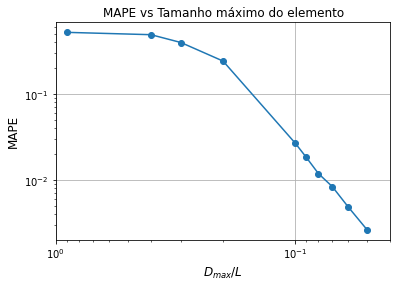

In [110]:
y_column = 'E2_fem'
x_column = 'max_size'

res = pd.DataFrame({'max_size':df_mesh['max_size']/0.01, y_column:df_mesh[y_column]})
res = res.drop([0,2,3,4,5], axis=0) #range3
res[y_column+'_true'] = df_mesh_true[y_column].iloc[0]
res['perc_error'] = 100*np.abs(res[y_column+'_true']-res[y_column])/res[y_column+'_true']
plt.plot(res['max_size'], res['perc_error'], marker='o')
plt.xlim(max(res['max_size'])+0.1, min(res['max_size'])-0.01)
plt.xscale('log')
plt.yscale('log')
plt.title('MAPE vs Tamanho máximo do elemento', fontsize=12)
plt.xlabel('$D_{max}/L$', fontsize=12)
plt.ylabel('MAPE', fontsize=12)
plt.grid(True)

#plt.savefig('convergencia_malha.png', dpi=500)

-------------------------------------------------------------------------------